In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./../csv/quntity_sum_sorted_by_date_complete.csv')

In [3]:
df['date'] = df['transaction_date'].rank(
    method='dense').astype(int)
df['day_number'] = pd.to_datetime(df['transaction_date']).dt.day

In [4]:
df.tail()

,transaction_date,store_id,product_id,transaction_qty,day_of_week,date,day_number
39667,2024-05-31,3,83,0.0,4,152,31
39668,2024-05-31,3,84,3.0,4,152,31
39669,2024-05-31,3,85,0.0,4,152,31
39670,2024-05-31,3,86,0.0,4,152,31
39671,2024-05-31,3,87,5.0,4,152,31


In [5]:
# Load the data
df_product = pd.read_csv('../csv/product_descriptions.csv')

# Create a dictionary for each column with unique values
product_category_dict = {k: v for v, k in enumerate(
    df_product['product_category'].unique())}
product_type_dict = {k: v for v, k in enumerate(df_product['product_type'].unique())}
# product_detail_dict = {k: v for v, k in enumerate(
#     df_product['product_detail'].unique())}

# Replace the original values with the corresponding dictionary values
df_product['product_category'] = df_product['product_category'].map(
    product_category_dict).astype(int)
df_product['product_type'] = df_product['product_type'].map(
    product_type_dict).astype(int)
# df_product['product_detail'] = df_product['product_detail'].map(
#     product_detail_dict).astype(int)

# df_product.to_csv('product_description_encoded.csv', index=False)
df_product.head()

,product_id,product_category,product_type,product_detail
0,1,0,0,French Butter Croissant
1,2,0,1,Blueberry Muffin
2,3,0,2,Apple Danish
3,4,0,2,Cherry Danish
4,5,0,3,Vanilla Sponge Cake


In [182]:
# Create a dictionary to map 'product_id' to 'product_category'
product_id_to_category_dict = df_product.set_index(
    'product_id')['product_category'].to_dict()

# Create a dictionary to map 'product_id' to 'product_type'
product_id_to_type_dict = df_product.set_index(
    'product_id')['product_type'].to_dict()

# Create a dictionary to map 'product_id' to 'product_detail'
product_id_to_detail_dict = df_product.set_index(
    'product_id')['product_detail'].to_dict()

In [7]:
# Assuming df_product is already loaded and has the same 'product_id' column
df = df.merge(df_product, on='product_id', how='left')
# Replace NaN values with a unique value
df.fillna(-1, inplace=True)

df.head()
df.to_csv('./../csv/product_description_added.csv', index=False)

In [8]:
# unique_dates = df[[
#     'transaction_date']].drop_duplicates().values
# # Split the dates into 80:20 train and test sets
df.head()

,transaction_date,store_id,product_id,transaction_qty,day_of_week,date,day_number,product_category,product_type,product_detail
0,2024-01-01,1,1,0.0,0,1,1,0.0,0.0,French Butter Croissant
1,2024-01-01,1,2,0.0,0,1,1,0.0,1.0,Blueberry Muffin
2,2024-01-01,1,3,0.0,0,1,1,0.0,2.0,Apple Danish
3,2024-01-01,1,4,0.0,0,1,1,0.0,2.0,Cherry Danish
4,2024-01-01,1,5,0.0,0,1,1,0.0,3.0,Vanilla Sponge Cake


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# from torch.utils.data.dataset import random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [112]:
# 'day_of_week', 'product_category', 'product_type', 'date'
class SalesDataset(Dataset):
    def __init__(self, df, unique_dates=None, days_per_batch=None, features=8, normalize=True):
        self.df = df.sort_values('transaction_date')
        self.unique_dates = df['transaction_date'].unique() if unique_dates is None else unique_dates        
        self.days_per_batch = min(len(self.unique_dates) - 1, days_per_batch) if days_per_batch is not None else len(self.unique_dates) - 1
        self.num_records_per_day = len(
            df[df['transaction_date'] == self.unique_dates[0]])
        print("Unique days", len(self.unique_dates))
        print("No. recs per day", self.num_records_per_day)

        # Create a tensor to hold all the data
        self.data_tensor = torch.zeros(
            (len(self.unique_dates), self.num_records_per_day, features), dtype=torch.float)
        self.target_tensor = torch.zeros(
            (len(self.unique_dates), self.num_records_per_day), dtype=torch.float)

        for i, date in enumerate(self.unique_dates[:-1]):
            current_data = self.df[self.df['transaction_date'] == date]
            data = current_data[['store_id', 'product_id',
                                 'transaction_qty', 'day_of_week', 'product_category', 'product_type', 'date', 'day_number']].values
            if normalize:
                data = scaler.fit_transform(data)
            # Get next day's data
            next_date = self.unique_dates[i + 1]
            next_data = self.df[self.df['transaction_date'] == next_date]
            target = next_data['transaction_qty'].values

            self.data_tensor[i] = torch.tensor(data, dtype=torch.float)
            self.target_tensor[i] = torch.tensor(target, dtype=torch.float)

    def __len__(self):
        return len(self.unique_dates) - self.days_per_batch

    def __getitem__(self, idx):
        # Just index into the precomputed tensors
        sequence_data = self.data_tensor[idx :idx+self.days_per_batch]
        # targets are the next day's transaction quantities
        sequence_target = self.target_tensor[idx: idx+self.days_per_batch]

        return sequence_data, sequence_target

In [113]:
# print(df.head(2))
pd.set_option('display.float_format', '{:.2f}'.format)
print(df.describe())

       store_id  product_id  transaction_qty  day_of_week     date  \
count  39672.00    39672.00         39672.00     39672.00 39672.00   
mean       2.00       44.00             4.12         2.97    76.50   
std        0.82       25.11             4.55         1.99    43.88   
min        1.00        1.00             0.00         0.00     1.00   
25%        1.00       22.00             0.00         1.00    38.75   
50%        2.00       44.00             3.00         3.00    76.50   
75%        3.00       66.00             7.00         5.00   114.25   
max        3.00       87.00            32.00         6.00   152.00   

       day_number  product_category  product_type  
count    39672.00          39672.00      39672.00  
mean        15.71              3.21         14.25  
std          8.79              2.52          8.38  
min          1.00             -1.00         -1.00  
25%          8.00              1.00          8.00  
50%         16.00              3.00         16.00  
75%  

In [114]:
# Split the unique dates into training and test sets
unique_dates = df['transaction_date'].unique()
train_dates, test_dates = train_test_split(
    unique_dates, test_size=0.3, shuffle=False)

In [115]:
days_per_batch = None
train_dataset = SalesDataset(df, unique_dates=train_dates, days_per_batch=days_per_batch)
test_dataset = SalesDataset(df, unique_dates=test_dates, days_per_batch=days_per_batch)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Unique days 106
No. recs per day 261
Unique days 46
No. recs per day 261


In [116]:
print(len(train_dates))
print(len(test_dates))
print(len(train_dataloader))
print(len(test_dataloader))
print(len(train_dates[0]))

106
46
1
1
10


In [117]:
data_iter = iter(train_dataloader)
print(data_iter)
batch1 = next(data_iter)
print("length: ", len(batch1))
print("data length: ", len(batch1[0]))
print("target length: ", len(batch1[1]))
print("data: ", batch1[0][0].shape)
print("target: ", batch1[1][0].shape)

length:  2
data length:  1
target length:  1
data:  torch.Size([105, 261, 8])
target:  torch.Size([105, 261])


In [16]:
# class Attention(nn.Module):
#     def __init__(self, hidden_layer_size):
#         super(Attention, self).__init__()
#         self.attention = nn.Linear(hidden_layer_size, 1)

#     def forward(self, lstm_out):
#         attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
#         context_vector = torch.sum(attn_weights * lstm_out, dim=1)
#         return context_vector, attn_weights


# class LSTM(nn.Module):
#     def __init__(self, input_size=261*8, hidden_layer_size=50, output_size=261, num_layers=2, dropout=0.5, bidirectional=False):
#         super(LSTM, self).__init__()
#         self.hidden_layer_size = hidden_layer_size
#         self.num_layers = num_layers
#         self.bidirectional = bidirectional

#         self.lstm = nn.LSTM(input_size, hidden_layer_size,
#                             num_layers=num_layers, dropout=dropout, batch_first=True, bidirectional=bidirectional)
#         self.dropout = nn.Dropout(dropout)

#         # If bidirectional, hidden_layer_size needs to be doubled for the attention layer input
#         attn_input_size = hidden_layer_size * 2 if bidirectional else hidden_layer_size
#         self.attention = Attention(attn_input_size)

#         # Output size for the linear layer remains the same
#         self.linear = nn.Linear(attn_input_size, output_size)

#     def forward(self, input_seq):
#         # Flatten the last two dimensions of the input
#         input_seq = input_seq.view(input_seq.shape[0], input_seq.shape[1], -1)

#         h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), input_seq.size(
#             0), self.hidden_layer_size).to(input_seq.device)
#         c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), input_seq.size(
#             0), self.hidden_layer_size).to(input_seq.device)

#         lstm_out, _ = self.lstm(input_seq, (h0, c0))
#         lstm_out = self.dropout(lstm_out)

#         # Apply attention mechanism
#         context_vector, attn_weights = self.attention(lstm_out)

#         # Expand the context_vector to match the sequence length of lstm_out for sequence prediction
#         context_vector = context_vector.unsqueeze(
#             1).expand(-1, lstm_out.size(1), -1)

#         predictions = self.linear(context_vector)
#         return predictions, attn_weights

In [118]:
import torch
import torch.nn as nn

class CustomLSTM(nn.Module):
    def __init__(self,
                 input_size=261*8,
                 hidden_layer_size=50,
                 lstm_output_size=261,
                 num_layers=2,
                 dropout=0.5,
                 bidirectional=False,
                 pre_lstm_dense_layers=[512, 256],
                 post_lstm_dense_layers=[128, 64]):
        super(CustomLSTM, self).__init__()

        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # Create pre-LSTM dense layers
        self.pre_lstm_dense = nn.ModuleList()
        current_input_size = input_size
        for layer_size in pre_lstm_dense_layers:
            self.pre_lstm_dense.append(
                nn.Linear(current_input_size, layer_size))
            self.pre_lstm_dense.append(nn.ReLU())
            self.pre_lstm_dense.append(nn.Dropout(dropout))
            current_input_size = layer_size

        # LSTM layer
        self.lstm = nn.LSTM(current_input_size, hidden_layer_size,
                            num_layers=num_layers, dropout=dropout, batch_first=True, bidirectional=bidirectional)

        # Adjust linear input size for bidirectional LSTM
        linear_input_size = hidden_layer_size * \
            2 if bidirectional else hidden_layer_size

        # Create post-LSTM dense layers
        self.post_lstm_dense = nn.ModuleList()
        for layer_size in post_lstm_dense_layers:
            self.post_lstm_dense.append(
                nn.Linear(linear_input_size, layer_size))
            self.post_lstm_dense.append(nn.ReLU())
            self.post_lstm_dense.append(nn.Dropout(dropout))
            linear_input_size = layer_size

        # Final output layer
        self.output_layer = nn.Linear(linear_input_size, lstm_output_size)

    def forward(self, input_seq):
        # Feed through pre-LSTM dense layers
        input_seq = input_seq.view(input_seq.shape[0], input_seq.shape[1], -1)

        for layer in self.pre_lstm_dense:
            input_seq = layer(input_seq)

        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1),
                         input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1),
                         input_seq.size(0), self.hidden_layer_size).to(input_seq.device)

        # LSTM forward pass
        lstm_out, _ = self.lstm(input_seq, (h0, c0))
        lstm_out = lstm_out[:, :, :]  # Select the last time step's output

        # Feed through post-LSTM dense layers
        for layer in self.post_lstm_dense:
            lstm_out = layer(lstm_out)

        # Final output layer
        predictions = self.output_layer(lstm_out)
        return predictions

# Example usage:
# model = CustomLSTM(input_size=261*8, hidden_layer_size=50, lstm_output_size=261,
#                    num_layers=2, dropout=0.5, bidirectional=False,
#                    pre_lstm_dense_layers=[512, 256], post_lstm_dense_layers=[128, 64])
# input_tensor = torch.randn((batch_size, sequence_length, input_size))
# output = model(input_tensor)

In [119]:
import torch
import torch.nn as nn


class LSTM(nn.Module):
    def __init__(self, input_size=261*8, hidden_layer_size=50, output_size=261, num_layers=2, dropout=0.5, bidirectional=False):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(input_size, hidden_layer_size,
                            num_layers=num_layers, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)

        # If bidirectional, hidden_layer_size needs to be doubled for the linear layer input
        linear_input_size = hidden_layer_size * \
            2 if bidirectional else hidden_layer_size
        self.linear = nn.Linear(linear_input_size, output_size)

    def forward(self, input_seq):
        # Flatten the last two dimensions of the input
        input_seq = input_seq.view(input_seq.shape[0], input_seq.shape[1], -1)

        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), input_seq.size(
            0), self.hidden_layer_size).to(input_seq.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), input_seq.size(
            0), self.hidden_layer_size).to(input_seq.device)

        lstm_out, _ = self.lstm(input_seq, (h0, c0))
        lstm_out = self.dropout(lstm_out)
        predictions = self.linear(lstm_out)
        predictions = predictions[:, :, :]  # Select the last time step prediction
        return predictions

In [120]:
model = CustomLSTM(input_size=261*8, hidden_layer_size=50, lstm_output_size=261,
                   num_layers=2, dropout=0.5, bidirectional=False,
                   pre_lstm_dense_layers=[512, 256], post_lstm_dense_layers=[128, 64])
input_tensor = torch.randn((3, 152, 261*8))
output = model(input_tensor)

In [121]:
print(output.shape)

torch.Size([3, 152, 261])


In [122]:
def train_model(model, criterion, optimizer, dataloader, model_varient='lstm'):
    model.train()
    total_loss = 0

    for data, target in dataloader:
        optimizer.zero_grad()
        if model_varient == 'transformer':
            output = model(data, data)
        else:
            output = model(data)
        # print(output)
        # print(output.shape)
        # print(target.shape)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    # print(total_loss)
    return total_loss / len(dataloader)

In [123]:
def evaluate_model(model, criterion, dataloader, model_varient='lstm'):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for data, target in dataloader:
            if model_varient == 'transformer':
                output = model(data, data)
            else:
                output = model(data)
            # print(output.shape)
            # print(target.shape)
            loss = criterion(output, target)
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [124]:

def model_fit(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs=25, patience=10, model_variant='lstm', checkpoint=40):
    train_losses = []
    test_losses = []

    best_test_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        train_loss = train_model(model, criterion, optimizer, train_dataloader, model_variant)
        test_loss = evaluate_model(model, criterion, test_dataloader, model_variant)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1
        if (epoch + 1) % checkpoint == 0:
            print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return model, train_losses, test_losses

In [125]:
def plot_losses(train_losses, test_losses, figsize=(6, 3)):
    plt.figure(figsize=figsize)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [168]:
# # Initialize the model, loss function and optimizer
# model = LSTM(hidden_layer_size=8, num_layers=2, dropout=0.5, bidirectional=False)
model = CustomLSTM(input_size=261*8, hidden_layer_size=128, lstm_output_size=261,
                   num_layers=2, dropout=0.5, bidirectional=False,
                   pre_lstm_dense_layers=[], post_lstm_dense_layers=[])
print(model.parameters)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

<bound method Module.parameters of CustomLSTM(
  (pre_lstm_dense): ModuleList()
  (lstm): LSTM(2088, 128, num_layers=2, batch_first=True, dropout=0.5)
  (post_lstm_dense): ModuleList()
  (output_layer): Linear(in_features=128, out_features=261, bias=True)
)>


Epoch 5/100: Train Loss = 7.8603, Test Loss = 23.3644
Epoch 10/100: Train Loss = 7.8219, Test Loss = 23.2446
Early stopping triggered


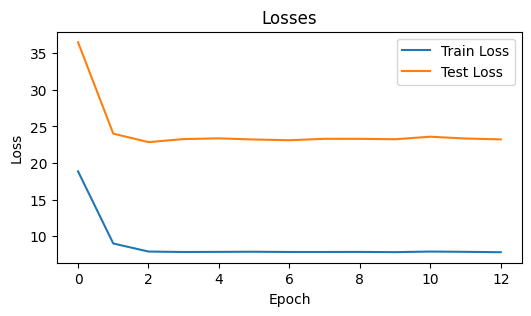

In [169]:
# Run model_fit
model, train_losses, test_losses = model_fit(
    model, loss_function, optimizer, train_dataloader, test_dataloader, num_epochs=100, checkpoint=5, patience=10, model_variant='lstm')

plot_losses(train_losses, test_losses, figsize=(6, 3))

In [170]:
df = pd.read_csv('./../csv/product_description_added.csv')

In [171]:
train_dates, test_dates = train_test_split(
    unique_dates, test_size=0.3, shuffle=False)


In [172]:
days_per_batch = 7
train_dataset = SalesDataset(df, train_dates, days_per_batch)
test_dataset = SalesDataset(df, test_dates, days_per_batch)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = LSTM(hidden_layer_size=24, num_layers=2)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Unique days 106
No. recs per day 261
Unique days 46
No. recs per day 261


Epoch 5/30: Train Loss = 9.1303, Test Loss = 24.0729
Epoch 10/30: Train Loss = 9.0102, Test Loss = 23.7440
Epoch 15/30: Train Loss = 8.9988, Test Loss = 23.4721
Epoch 20/30: Train Loss = 8.7062, Test Loss = 23.2945
Epoch 25/30: Train Loss = 8.8631, Test Loss = 23.4640
Early stopping triggered


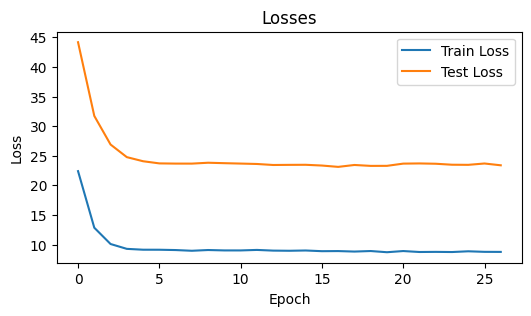

In [173]:
model, train_losses, test_losses = model_fit(
    model, loss_function, optimizer, train_dataloader, test_dataloader, num_epochs=30, checkpoint=5)
plot_losses(train_losses, test_losses)

In [176]:
days_per_batch = 30
train_dataset = SalesDataset(df, unique_dates, days_per_batch)
test_dataset = SalesDataset(df, test_dates, days_per_batch)
train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=False)

Unique days 152
No. recs per day 261
Unique days 46
No. recs per day 261


Epoch 3/20: Train Loss = 16.9543, Test Loss = 31.5986
Epoch 6/20: Train Loss = 11.4691, Test Loss = 22.1025
Epoch 9/20: Train Loss = 10.8818, Test Loss = 19.9762
Epoch 12/20: Train Loss = 10.8398, Test Loss = 19.3404
Epoch 15/20: Train Loss = 10.8478, Test Loss = 19.2447
Epoch 18/20: Train Loss = 10.7848, Test Loss = 19.2458


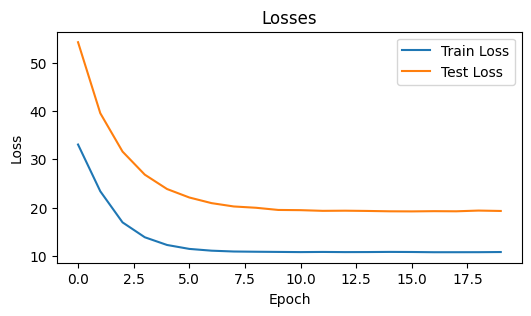

In [177]:
model = CustomLSTM(input_size=261*8, hidden_layer_size=30, lstm_output_size=261,
                   num_layers=2, dropout=0.5, bidirectional=False,
                   pre_lstm_dense_layers=[], post_lstm_dense_layers=[])
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
model, train_losses, test_losses = model_fit(
    model, loss_function, optimizer, train_dataloader, test_dataloader, num_epochs=20, checkpoint=3, patience=10)
plot_losses(train_losses, test_losses)

In [136]:
days_per_batch = 30
train_dataset = SalesDataset(df, train_dates, days_per_batch)
test_dataset = SalesDataset(df, test_dates, days_per_batch)
train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=False)

Unique days 106
No. recs per day 261
Unique days 46
No. recs per day 261


Epoch 40/200: Train Loss = 8.0775, Test Loss = 23.5598
Early stopping triggered


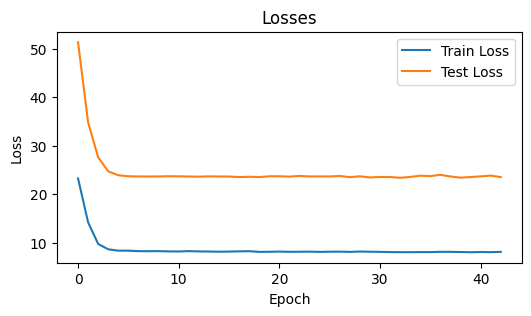

In [137]:
model = LSTM(hidden_layer_size=64, num_layers=8, dropout=0.5)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, test_losses = model_fit(
    model, loss_function, optimizer, train_dataloader, test_dataloader, num_epochs=200, checkpoint=40)
plot_losses(train_losses, test_losses)

Unique days 152
No. recs per day 261
Unique days 46
No. recs per day 261
Epoch 40: Train Loss = 18.2386, Test Loss = 30.4016
Epoch 80: Train Loss = 16.0484, Test Loss = 24.1326
Epoch 120: Train Loss = 15.2105, Test Loss = 22.8361
Epoch 160: Train Loss = 14.7563, Test Loss = 22.5587
Epoch 200: Train Loss = 15.2982, Test Loss = 22.1649
Epoch 200: Train Loss = 15.2982, Test Loss = 22.1649


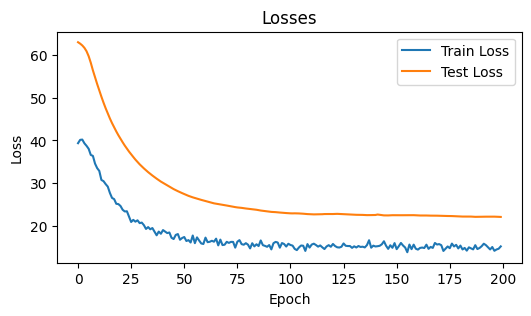

In [ ]:
days_per_batch = 20
train_dataset = SalesDataset(df, unique_dates, days_per_batch, normalize=True)
test_dataset = SalesDataset(df, test_dates, days_per_batch, normalize=True)
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=False)
model = LSTM(hidden_layer_size=16, num_layers=2, dropout=0.7)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
model, train_losses, test_losses = model_fit(
    model, loss_function, optimizer, train_dataloader, test_dataloader, num_epochs=200, checkpoint=40)
plot_losses(train_losses, test_losses)

In [ ]:
# days_per_batch = 30
# train_dataset = SalesDataset(df, train_dates, days_per_batch, normalize=True)
# test_dataset = SalesDataset(df, test_dates, days_per_batch, normalize=True)
# train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)
# model = TransformerModel()
# loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# model, train_losses, test_losses = model_fit(
#     model, loss_function, optimizer, train_dataloader, test_dataloader, num_epochs=200, checkpoint=40, model_varient='transformer')
# plot_losses(train_losses, test_losses)

In [180]:
print(df.dtypes)

transaction_date    datetime64[ns]
store_id                     int64
product_id                   int64
transaction_qty            float64
day_of_week                  int64
date                       float64
day_number                   int64
product_category           float64
product_type               float64
product_detail              object
dtype: object


In [190]:
from datetime import datetime, timedelta

df = pd.read_csv('../csv/product_description_added.csv')
# df = df.apply(lambda x: x.astype(float) if x.dtype.kind in 'biufc' else x)

# print(df.head())
# Initialize store_id, product_id and transaction_date
store_id = 1
product_id = 1
last_date = df['date'].max()
transaction_date = datetime.strptime('2024-06-01', '%Y-%m-%d')

# Create 261 new entries for each day, for 14 days
for day in range(14):
    print("Day: ", day)
    # Generate 261 predictions for the day
    dataset = SalesDataset(df, days_per_batch=None, normalize=True)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    data_iter = iter(dataloader)
    data, target = next(data_iter)
    predictions = model(data)
    # print(predictions[0, -1, 0].item())
    # print(predictions.shape)
    for i in range(261):
        # Append a new entry to the DataFrame
        new_entry = pd.DataFrame({
            'transaction_date': [transaction_date],
            'store_id': [store_id],
            'product_id': [product_id],
            'transaction_qty': [np.round(predictions[0, -1, i].item())],
            'date': [last_date + 1],
            'day_of_week': [transaction_date.weekday()],
            'day_number': [transaction_date.day],
            'product_category': [product_id_to_category_dict.get(product_id, -1)],
            'product_type': [product_id_to_type_dict.get(product_id, -1)],
            'product_detail': [product_id_to_detail_dict.get(product_id, -1)]
        })
        # new_entry = new_entry.astype(int, errors='ignore') 
        # print(new_entry)     
        # print(new_entry.dtypes)
        df = pd.concat([df, new_entry], ignore_index=True)
        # df.fillna(-1, inplace=True)
        df['transaction_date'] = pd.to_datetime(df['transaction_date'])
        
        # Update product_id and store_id for the next entry
        last_date += 1
        product_id += 1
        if product_id > 87:
            product_id = 1
            store_id += 1
        if store_id > 3:
            store_id = 1

    # Update transaction_date for the next day
    transaction_date += timedelta(days=1)

# At the end of the loop, new_entries contains 261 new entries for each day, for 14 days

Day:  0
Unique days 152
No. recs per day 261
Day:  1
Unique days 153
No. recs per day 261
Day:  2
Unique days 154
No. recs per day 261
Day:  3
Unique days 155
No. recs per day 261
Day:  4
Unique days 156
No. recs per day 261
Day:  5
Unique days 157
No. recs per day 261
Day:  6
Unique days 158
No. recs per day 261
Day:  7
Unique days 159
No. recs per day 261
Day:  8
Unique days 160
No. recs per day 261
Day:  9
Unique days 161
No. recs per day 261
Day:  10
Unique days 162
No. recs per day 261
Day:  11
Unique days 163
No. recs per day 261
Day:  12
Unique days 164
No. recs per day 261
Day:  13
Unique days 165
No. recs per day 261


In [191]:
df.to_csv('output.csv', index=False)

In [192]:
df.tail(261*14).to_csv('my_submission.csv', index=False)

In [193]:
df_filtered = df.drop(
    columns=['day_of_week', 'product_category', 'product_type', 'product_detail'])
# df_filtered.tail(261*14).to_csv('my_submission_final.csv')

In [194]:
df.tail

<bound method NDFrame.tail of       transaction_date  store_id  product_id  transaction_qty  day_of_week  \
0           2024-01-01         1           1             0.00            0   
1           2024-01-01         1           2             0.00            0   
2           2024-01-01         1           3             0.00            0   
3           2024-01-01         1           4             0.00            0   
4           2024-01-01         1           5             0.00            0   
...                ...       ...         ...              ...          ...   
43321       2024-06-14         3          83             0.00            4   
43322       2024-06-14         3          84             0.00            4   
43323       2024-06-14         3          85             2.00            4   
43324       2024-06-14         3          86             2.00            4   
43325       2024-06-14         3          87             0.00            4   

       date  day_number  product_

In [196]:
submission = pd.read_csv('../csv/submission_key.csv')
df_filtered['transaction_date'] = df_filtered['transaction_date'].dt.strftime(
    '%Y-%m-%d')
df_filtered['store_id'] = 'ST' + df_filtered['store_id'].astype(str)
# Merge df_filtered and submission on all columns
df_filtered = df_filtered.merge(submission, how='inner')

In [201]:
df_filtered = df_filtered[['ID', 'transaction_date',
                           'store_id', 'product_id', 'transaction_qty']]
df_filtered.to_csv('./../csv/my_submission_final.csv', index=False)

In [202]:
df_final = df_filtered[['ID', 'transaction_qty']].rename(
    columns={'transaction_qty': 'sold_qty'})
df_final.to_csv('./../my_submission_final.csv', index=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


class TransformerModel(nn.Module):
    def __init__(self, input_size=261*8, output_size=261, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_size = input_size
        self.d_model = d_model

        self.embedding = nn.Linear(input_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        self.transformer = nn.Transformer(
            d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
        self.fc_out = nn.Linear(d_model, output_size)

    def forward(self, src, tgt):
        # Apply embedding and positional encoding
        src = self.embedding(
            src) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        tgt = self.embedding(
            tgt) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))

        src = self.positional_encoding(src)
        tgt = self.positional_encoding(tgt)

        # Transformer expects inputs in shape (seq_len, batch_size, d_model)
        src = src.transpose(0, 1)
        tgt = tgt.transpose(0, 1)

        output = self.transformer(src, tgt)
        output = self.fc_out(output)

        # Return the output in shape (batch_size, seq_len, output_size)
        return output.transpose(0, 1)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float(
        ) * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Data preparation


class SalesDataset(Dataset):
    def __init__(self, df, unique_dates=None, days_per_batch=None, features=8, normalize=True):
        self.df = df.sort_values('transaction_date')
        self.unique_dates = df['transaction_date'].unique(
        ) if unique_dates is None else unique_dates
        self.days_per_batch = len(self.unique_dates) - \
            1 if days_per_batch is None else days_per_batch
        self.num_records_per_day = len(
            df[df['transaction_date'] == self.unique_dates[0]])
        print("Unique days", len(self.unique_dates))
        print("No. recs per day", self.num_records_per_day)

        self.data_tensor = torch.zeros(
            (len(self.unique_dates), self.num_records_per_day, features), dtype=torch.float)
        self.target_tensor = torch.zeros(
            (len(self.unique_dates), self.num_records_per_day), dtype=torch.float)

        for i, date in enumerate(self.unique_dates[:-1]):
            current_data = self.df[self.df['transaction_date'] == date]
            data = current_data[['store_id', 'product_id', 'transaction_qty', 'day_of_week',
                                 'product_category', 'product_type', 'date', 'day_number']].values
            if normalize:
                data = scaler.fit_transform(data)
            next_date = self.unique_dates[i + 1]
            next_data = self.df[self.df['transaction_date'] == next_date]
            target = next_data['transaction_qty'].values

            self.data_tensor[i] = torch.tensor(data, dtype=torch.float)
            self.target_tensor[i] = torch.tensor(target, dtype=torch.float)

    def __len__(self):
        return len(self.unique_dates) - self.days_per_batch

    def __getitem__(self, idx):
        sequence_data = self.data_tensor[idx:idx+self.days_per_batch]
        sequence_target = self.target_tensor[idx+1:idx+self.days_per_batch+1]
        return sequence_data, sequence_target

# Ensure DataLoader is instantiated
# Example:
# train_dataloader = DataLoader(SalesDataset(train_df), batch_size=32, shuffle=True)
# test_dataloader = DataLoader(SalesDataset(test_df), batch_size=32, shuffle=False)

In [ ]:
import matplotlib.pyplot as plt


def train_model(model, criterion, optimizer, dataloader):
    model.train()
    total_loss = 0
    for data, target in dataloader:
        optimizer.zero_grad()
        # Using data as both src and tgt for simplicity
        output = model(data, data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate_model(model, criterion, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in dataloader:
            # Using data as both src and tgt for simplicity
            output = model(data, data)
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(dataloader)

# Example model fitting function


def model_fit(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs, checkpoint):
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        train_loss = train_model(model, criterion, optimizer, train_dataloader)
        test_loss = evaluate_model(model, criterion, test_dataloader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if epoch % checkpoint == 0:
            print(f'Epoch {epoch}, Train Loss: {
                  train_loss:.4f}, Test Loss: {test_loss:.4f}')
    return model, train_losses, test_losses


# Plotting function


def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()
    plt.show()


# Example usage
model = TransformerModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
model, train_losses, test_losses = model_fit(
    model, loss_function, optimizer, train_dataloader, test_dataloader, num_epochs=200, checkpoint=40)
plot_losses(train_losses, test_losses)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (78300x8 and 2088x512)